In [ ]:
import sys
sys.path.insert(0,'../scripts')
import plot_settings
from plot_settings  import palette

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bootstrap
import pandas as pd
from tqdm import tqdm

df = pd.read_csv('../data/figure_6_revised_data.csv').rename(columns={'nunsat':'unsat'})
df['ind'] = df['graph'].str.extract(r'(\d+).pubo').astype(int)
df = df.query('ind <= 45')
# print(df.keys())
df["Method"] = "None"
# df["Annealing"] = "Static Potential"
df.loc[(df['anneal-power'] != 0.0)  & (df['quadratic-model'] == "H1"), 'Method'] = "Annealed"
df.loc[ (df['quadratic-model'] == "H4"), 'Method'] = "Static"
# df.loc[(df['anneal-power'] == 0.0), 'Method'] = "Static Potential"
df.loc[(df['anneal-power'] == 0.0) & (df['quadratic-model'] == "H1") & (df['shil-coeff'] == 1.0), 'Method'] = "SHIL"
# df.loc[(df['shil-coeff'] == 0.0) & (df['anneal-power'] == 0.0)  & (df['quadratic-model'] == "H1"), 'Method'] = "None"
# df.query('Method == "None"')
df['M'] = 430
df['% SAT'] = (1-df["unsat"] / df['M']) * 100
df["Solved"] = df['unsat'] == 0
bootstrap_data = []
for (m,), sdf in tqdm(df.groupby(['Method'])):
    statistics = lambda x: [
        np.mean(x <= i) for i in range(12)
        ]
    point_estimate = bootstrap([sdf['unsat']], statistic=statistics, confidence_level=0.99, n_resamples=10_000)
    lvals = point_estimate.confidence_interval.low
    hvals = point_estimate.confidence_interval.high
    estimates = statistics(sdf['unsat'])
    for i in range(len(estimates)):
        bootstrap_data.append((m, i, estimates[i], lvals[i], hvals[i]))

  0%|          | 0/4 [00:00<?, ?it/s]/home/matt/miniforge3/envs/ot/lib/python3.12/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/home/matt/miniforge3/envs/ot/lib/python3.12/site-packages/scipy/_lib/_util.py:352: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)
100%|██████████| 4/4 [00:06<00:00,  1.59s/it]


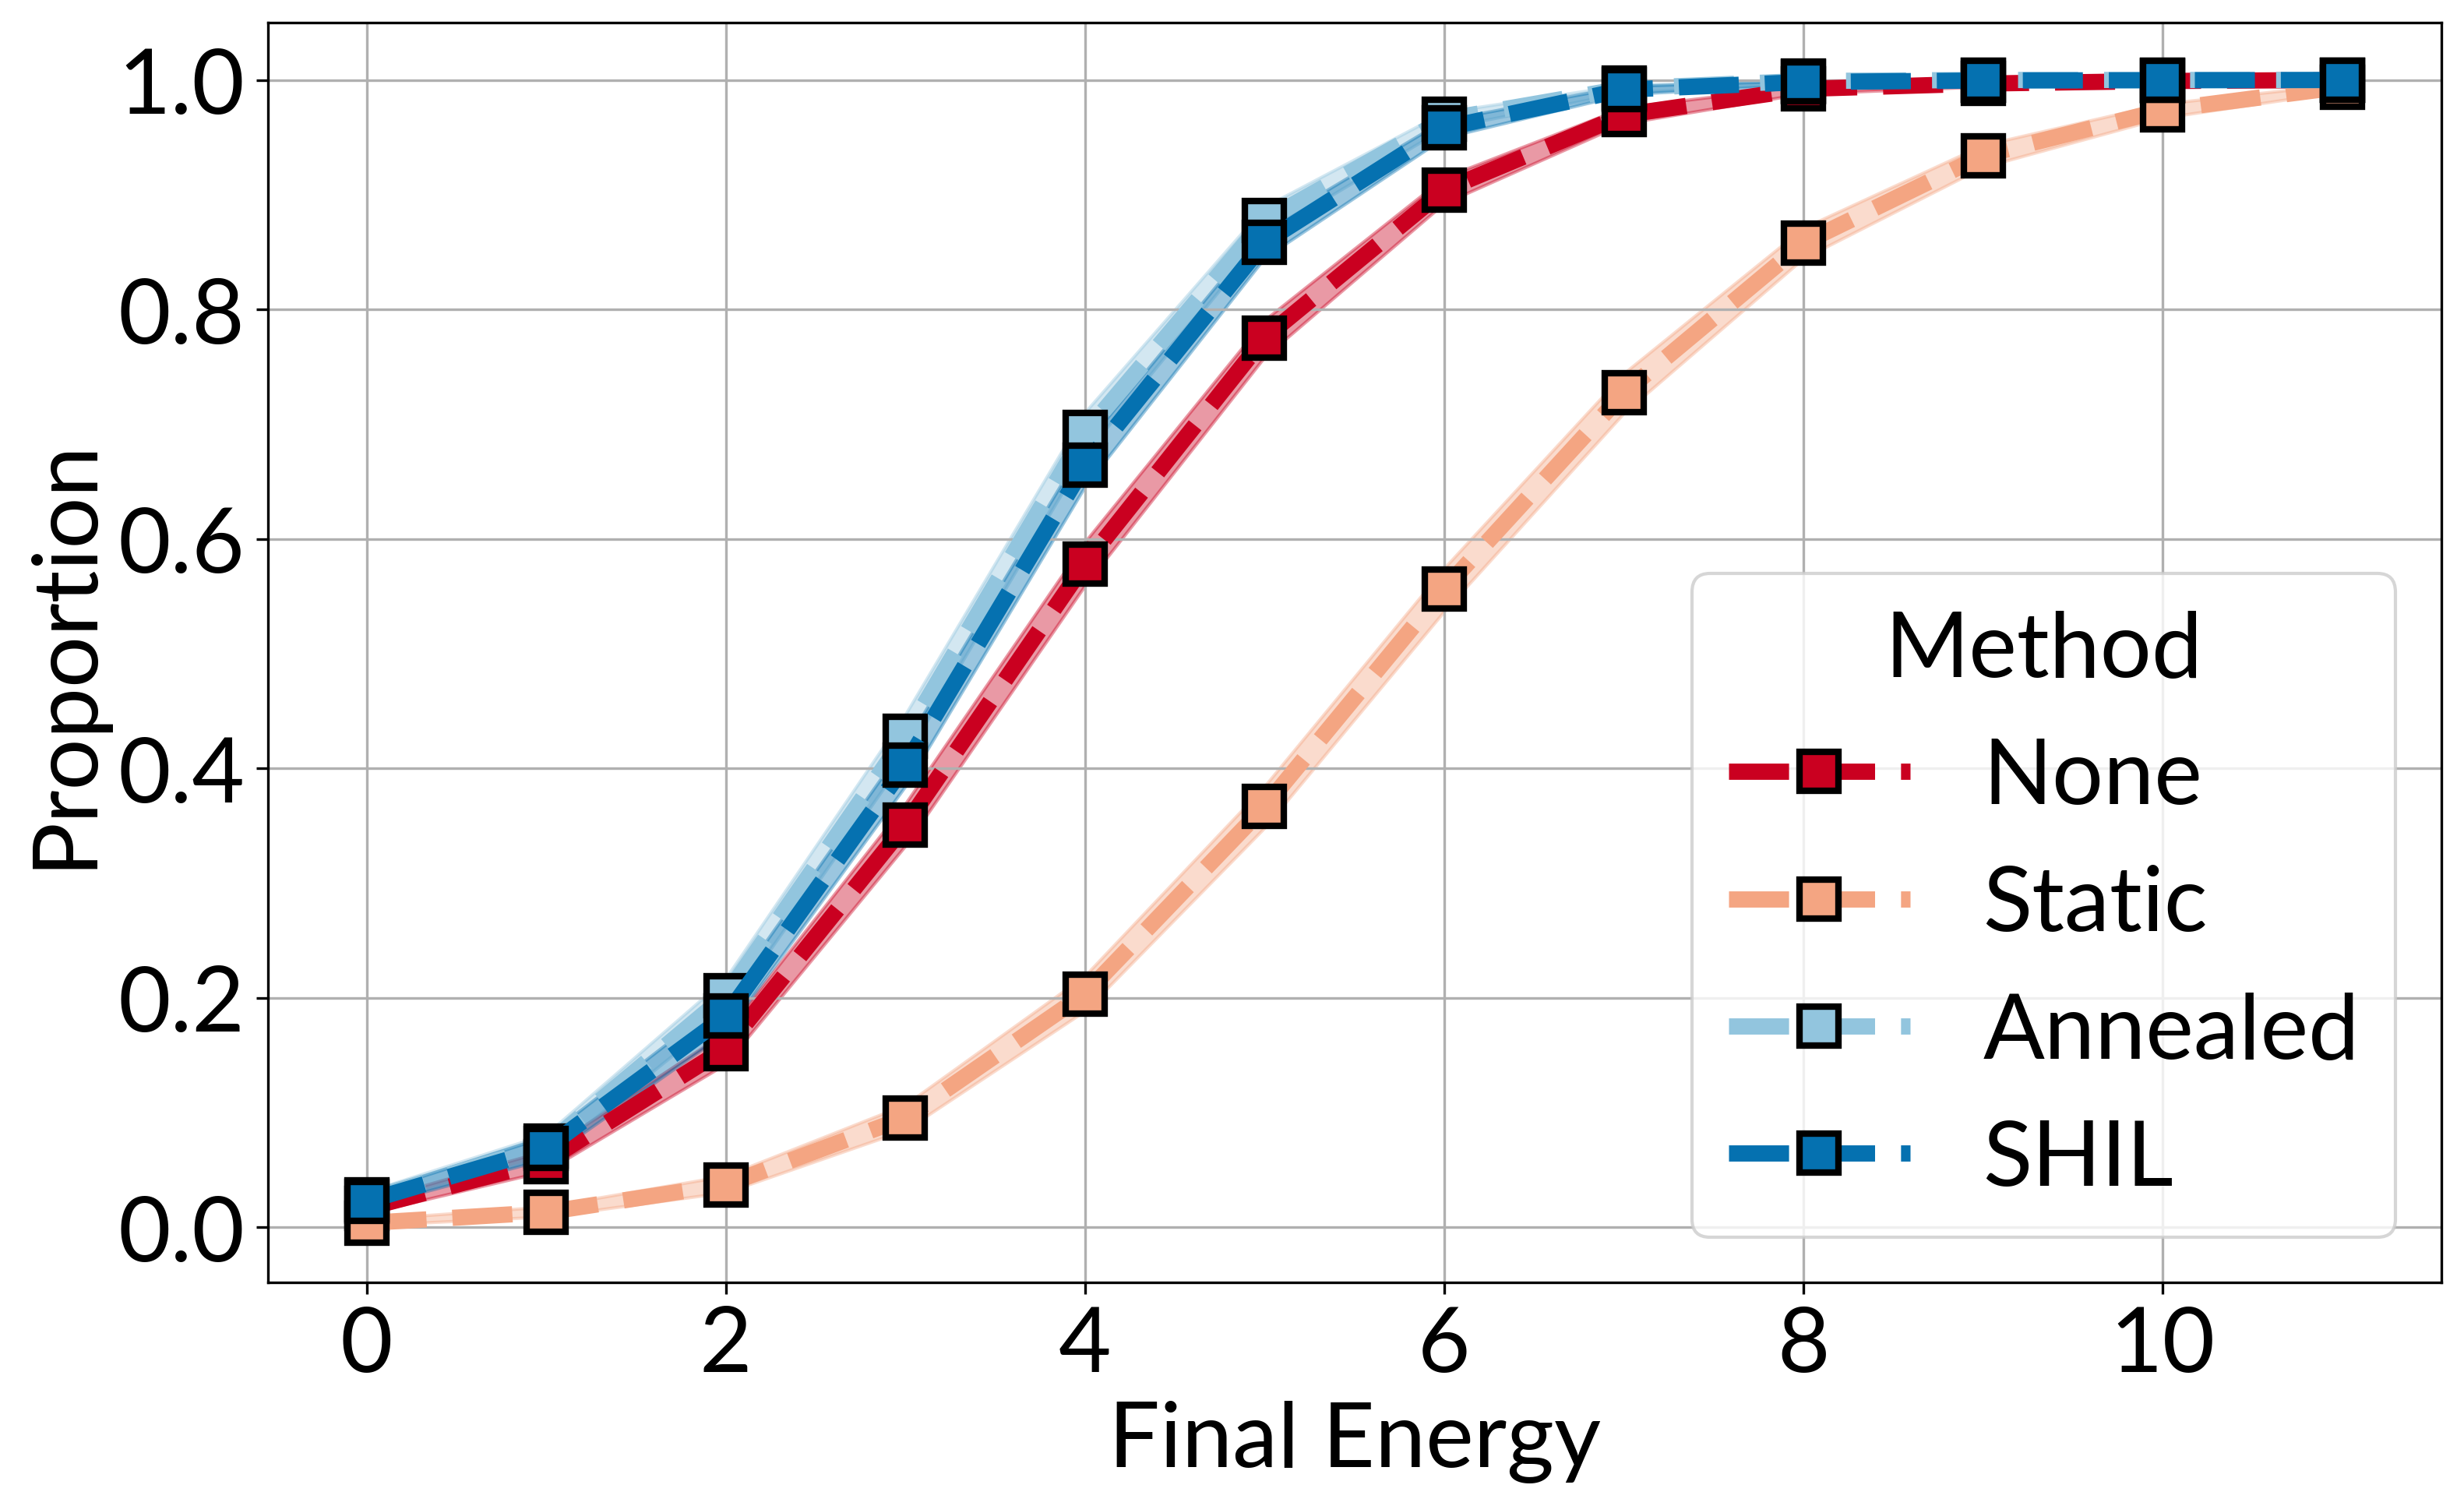

In [3]:
bootstrap_df = pd.DataFrame(bootstrap_data, columns=['Method', 'unsat', 'nunsat', 'low_unsat', 'high_unsat'])
fig, ax = plt.subplots(figsize=(12,7))
# palette = sns.color_palette()
sns.lineplot(bootstrap_df, 
             ax=ax, 
             x='unsat', 
             y='nunsat', 
             hue='Method', 
             palette=palette, 
             hue_order=['None', 'Static', 'Annealed', 'SHIL'],
             linestyle='--',
             marker='s',
             markersize=12,
             markeredgewidth=2,
             markeredgecolor='k',
             linewidth=5)
for c, m in enumerate(['None', 'Static', 'Annealed', 'SHIL']):
    subdf = bootstrap_df.query(f'Method == "{m}"')
    ax.fill_between(x=subdf['unsat'], y1=subdf['low_unsat'], y2=subdf['high_unsat'], color=(*palette[c], 0.4))
ax.set_ylabel('Proportion')
ax.set_xlabel("Final Energy")
    # sns.lineplot( x='unsat', y='nunsat', hue='Method', color=palette[c])
ax.grid()
fig.savefig('../figures/fig_6.pdf', bbox_inches='tight')